In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from statsmodels.tsa import ar_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [2]:
df = pd.read_csv('data3.csv')

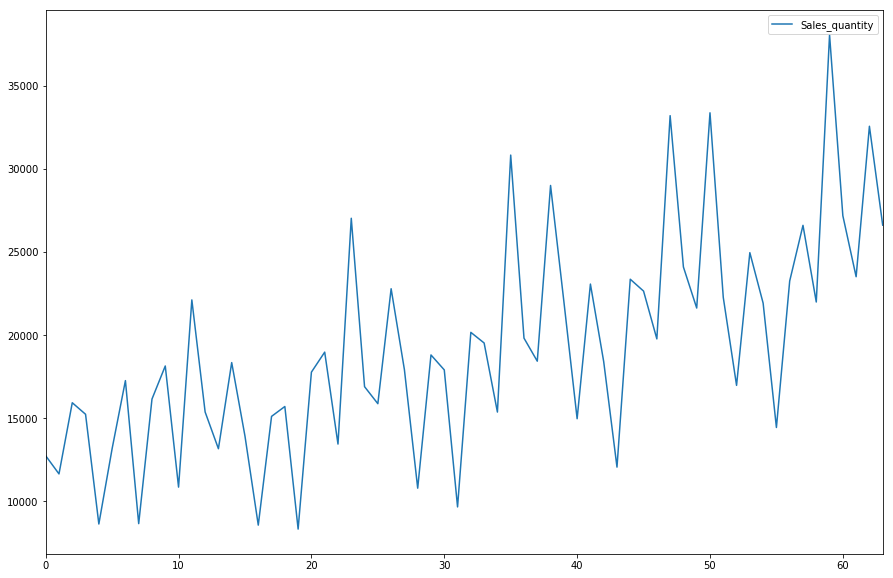

In [3]:
df.plot(figsize=(15,10))

In [4]:
train = df[0:50].copy()
test = df[50:].copy()
test = test.reset_index()

## Create an LSTM model



## Step 1: create input for the model

In order to create an LSTM model, we have to generate the correct features.

The way we do this is to first create a function "create_features" that takes series and the lag, and create batches of features, which will be the input to the network.

The output of the network will be the target of the last timestep.

So the first sample will be [T1, T2, T3] and the target will be T4

In [5]:
def create_features(sequence, lag):
    X, y = [], []
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + lag
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
lag = 3
# split into features
X, y = create_features(train.Sales_quantity, lag)

val_X, val_y = create_features(test.Sales_quantity, lag)

for i in range(len(X)):
    print(X[i], y[i])

[12729. 11636. 15922.] 15227.0
[11636. 15922. 15227.] 8620.0
[15922. 15227.  8620.] 13160.0
[15227.  8620. 13160.] 17254.0
[ 8620. 13160. 17254.] 8642.0
[13160. 17254.  8642.] 16144.0
[17254.  8642. 16144.] 18135.0
[ 8642. 16144. 18135.] 10841.0
[16144. 18135. 10841.] 22113.0
[18135. 10841. 22113.] 15365.0
[10841. 22113. 15365.] 13153.0
[22113. 15365. 13153.] 18339.0
[15365. 13153. 18339.] 13909.0
[13153. 18339. 13909.] 8553.0
[18339. 13909.  8553.] 15101.0
[13909.  8553. 15101.] 15695.0
[ 8553. 15101. 15695.] 8314.0
[15101. 15695.  8314.] 17764.0
[15695.  8314. 17764.] 18969.0
[ 8314. 17764. 18969.] 13433.0
[17764. 18969. 13433.] 27029.0
[18969. 13433. 27029.] 16889.0
[13433. 27029. 16889.] 15864.0
[27029. 16889. 15864.] 22786.0
[16889. 15864. 22786.] 17910.0
[15864. 22786. 17910.] 10777.0
[22786. 17910. 10777.] 18799.0
[17910. 10777. 18799.] 17899.0
[10777. 18799. 17899.] 9649.0
[18799. 17899.  9649.] 20159.0
[17899.  9649. 20159.] 19519.0
[ 9649. 20159. 19519.] 15360.0
[20159. 19519

## Create a simple LSTM model

We need to define a model with just 2 layers:

- The first layer will be an LSTM layer
- The second layer will be a Dense layer with a single target

Use Keras in order to create the network

https://keras.io/api/

In [7]:
# define model
n_features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(lag, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

## Fitting the network with the data

In [8]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], n_features))

In [9]:
X.shape

(47, 3, 1)

In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [11]:
hist = model.fit(X, y, epochs=150, verbose=0, validation_data=(val_X, val_y), callbacks=[es])

In [12]:
X[-1]

array([[19765.],
       [33207.],
       [24096.]])

## Create predictions on the train set and validate

Create a plot showing the train predictions vs the real target

In [13]:
pred = model.predict(X[1].reshape((1, lag, n_features)))

In [14]:
train_preds = model.predict(X)

In [15]:
train_preds = [pred[0] for pred in train_preds]

In [16]:
t2 = train.tail(train.shape[0]-lag).copy()

In [17]:
t2['pred'] = train_preds

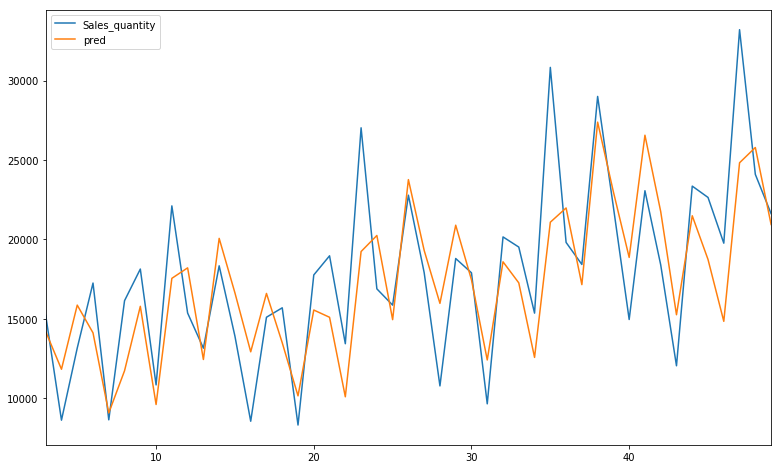

In [18]:
t2.plot(figsize=(13,8))

## Create predictions on the test set and Validate

In [19]:
def create_predictions(n_preds, last_sample):
    preds = []
    features = last_sample.reshape((1, lag, n_features))
    for i in range(0, n_preds):
        prediction = model.predict(features)[0][0]
        preds.append(prediction)
        features = np.delete(features, 0, axis=1)
        features = np.append(features, [[[prediction]]], axis=1)
    return preds

In [20]:
preds = create_predictions(len(test), X[-1])

In [21]:
test['pred'] = preds

In [22]:
test = test.set_index('index')

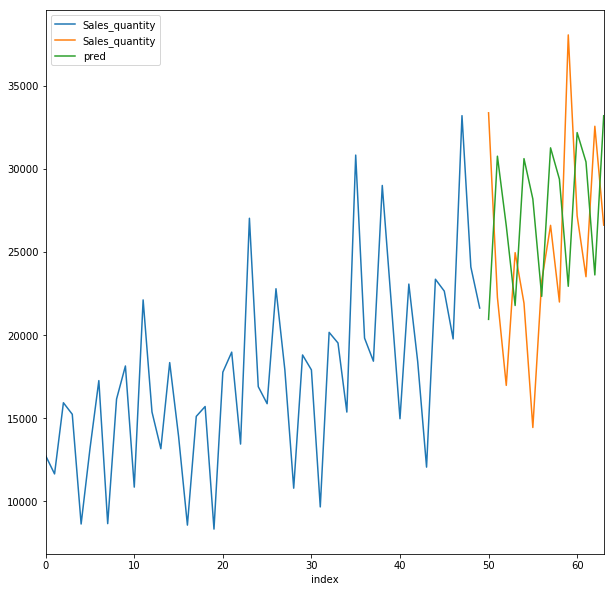

In [23]:
ax = train.plot(figsize=(10,10))
test.plot(ax=ax)